# WeatherNet

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import zipfile
import torch
import seaborn as sns
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn


In [2]:
print(torch.__version__)


2.3.1+cu121


In [3]:
path_rsc = './dataaets/dataset_rsc'
path_fog = '/dataaets/dataset_fog'

In [4]:
#zip_path_weather_image_recognition = './dataaets/weather-dataset.zip'
#zip_path_weather_detection_image_dataset = 'dataaets/потомскачаю'
#
#with zipfile.ZipFile(zip_path_weather_image_recognition, 'r') as zip_ref:
#    zip_ref.extractall('.')

#### Создаем свои кастомные датасэты

In [5]:
class rscDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.im_paths = [im_path for im_path in sorted(glob(f"{root_dir}/*/*.jpg"))]
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1



                
    def get_class(self, path): return os.path.basename(os.path.dirname(path))
    
    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transform is not None:
            im = self.transform(im)
        return im, gt
        
def get_dls(root,batch_size, transforms,  split=[0.8, 0.06, 0.1], ns=4):

    data = rscDataset(root_dir=root, transform=transform)
    total_len = len(data)
    train_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - (train_len + val_len)

    train_set, val_set, test_set = random_split(dataset=data, lengths=[train_len, val_len, test_len])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers = ns)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers = ns)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers = ns)

    return train_loader, val_loader, test_loader, data.cls_names


Задаем параметры

In [14]:
mean, std, img_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])
tr_dl, val_dl, test_dl, classes = get_dls(root = path_rsc, transforms = transform, batch_size = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(test_dl)); print(classes)


188
15
33
{'clear': 0, 'rain': 1, 'snow': 2}


#### Визуализация

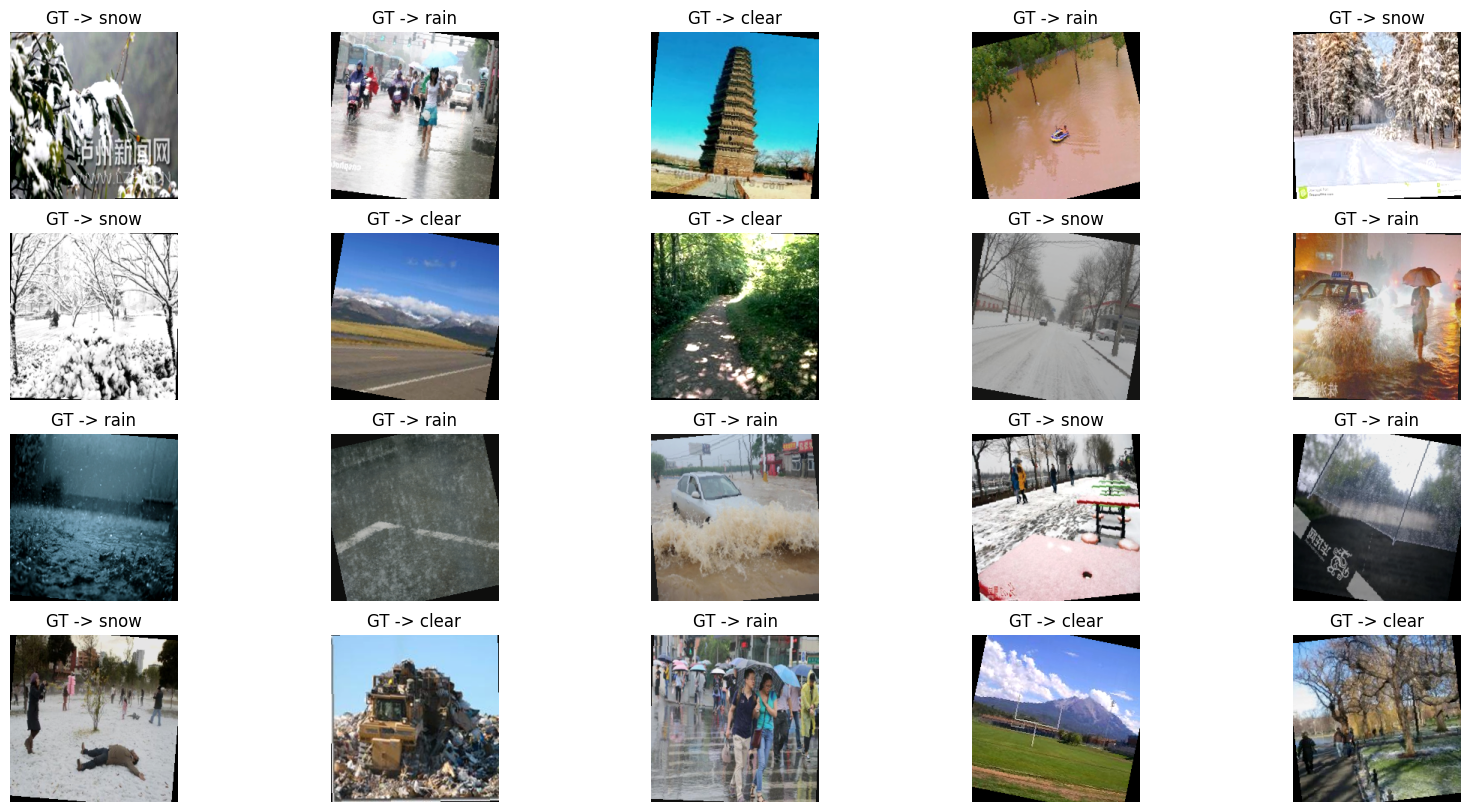

In [12]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = transforms.Compose([transforms.Normalize(mean = [ 0.], std = [1/0.5]), transforms.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

Настраиваем параметры

In [15]:
lr = 0.001
num_epochs = 10

#### Обучение
Используем предобученную модель resnet50 из библиотеки timm

In [24]:
import timm
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m = timm.create_model("resnet50", pretrained = True, num_classes = len(classes), drop_rate=0.15)
m = m.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=m.parameters(), lr = lr, weight_decay=1e-5, betas=(0.9, 0.999))
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

In [25]:


save_prefix, save_dir = "weather", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5

for epoch in range(num_epochs):
    
    m.train()
    epoch_loss, epoch_acc = 0, 0
    for i, batch in tqdm(enumerate(tr_dl)):
    
        ims = batch[0].to(device)
        gts = batch[1].to(device)
        pred = m(ims)
        loss = loss_fn(pred, gts)
        
        epoch_loss += loss.item()
        epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        
    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track)
    
    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for i, batch in tqdm(enumerate(val_dl)):
            ims = batch[0].to(device)
            gts = batch[1].to(device)
            pred = m(ims)
            loss = loss_fn(pred, gts)

            pred_cls = torch.argmax(pred.data, dim = 1)
            val_epoch_loss += loss.item()
            val_epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
            
        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break
    

Start training...


188it [00:31,  5.97it/s]

1-epoch train process is completed!
1-epoch train loss          -> 0.391
1-epoch train accuracy      -> 0.851



15it [00:01, 13.55it/s]


1-epoch validation process is completed!
1-epoch validation loss     -> 0.160
1-epoch validation accuracy -> 0.956


188it [00:31,  5.95it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.200
2-epoch train accuracy      -> 0.929



15it [00:01, 13.57it/s]


2-epoch validation process is completed!
2-epoch validation loss     -> 0.154
2-epoch validation accuracy -> 0.960


188it [00:31,  5.92it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.133
3-epoch train accuracy      -> 0.954



15it [00:01, 13.69it/s]


3-epoch validation process is completed!
3-epoch validation loss     -> 0.152
3-epoch validation accuracy -> 0.942


188it [00:31,  5.88it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.122
4-epoch train accuracy      -> 0.957



15it [00:01, 12.89it/s]

4-epoch validation process is completed!
4-epoch validation loss     -> 0.307
4-epoch validation accuracy -> 0.960
Loss value did not decrease for 1 epochs



188it [00:31,  5.90it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.095
5-epoch train accuracy      -> 0.966



15it [00:01, 13.27it/s]


5-epoch validation process is completed!
5-epoch validation loss     -> 0.082
5-epoch validation accuracy -> 0.964


188it [00:31,  5.90it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.089
6-epoch train accuracy      -> 0.968



15it [00:01, 13.94it/s]


6-epoch validation process is completed!
6-epoch validation loss     -> 0.091
6-epoch validation accuracy -> 0.960


188it [00:31,  5.90it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.078
7-epoch train accuracy      -> 0.975



15it [00:01, 13.57it/s]

7-epoch validation process is completed!
7-epoch validation loss     -> 0.111
7-epoch validation accuracy -> 0.964
Loss value did not decrease for 2 epochs



188it [00:31,  5.88it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.107
8-epoch train accuracy      -> 0.965



15it [00:01, 13.62it/s]

8-epoch validation process is completed!
8-epoch validation loss     -> 0.316
8-epoch validation accuracy -> 0.920
Loss value did not decrease for 3 epochs



188it [00:32,  5.87it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.065
9-epoch train accuracy      -> 0.977



15it [00:01, 13.87it/s]

9-epoch validation process is completed!
9-epoch validation loss     -> 0.119
9-epoch validation accuracy -> 0.973
Loss value did not decrease for 4 epochs



188it [00:32,  5.86it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.043
10-epoch train accuracy      -> 0.986



15it [00:01, 14.42it/s]


10-epoch validation process is completed!
10-epoch validation loss     -> 0.056
10-epoch validation accuracy -> 0.982


0.016655304173279244

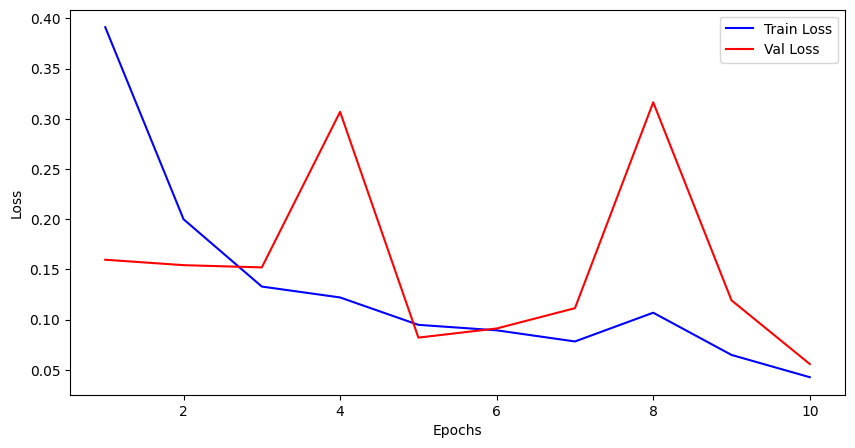

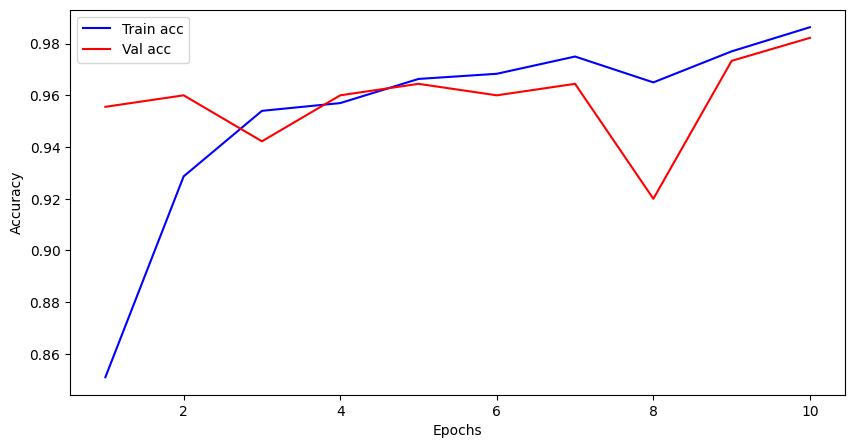

In [26]:
num_epoch2 = [x+1 for x in range(len(tr_losses))]

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
sns.lineplot(x=num_epoch2, y=tr_losses, label = "Train Loss", color = "blue")
sns.lineplot(x=num_epoch2, y=val_losses, label = "Val Loss", color = "red")
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
sns.lineplot(x=num_epoch2, y=tr_accs, label = "Train acc", color = "blue")
sns.lineplot(x=num_epoch2, y=val_accs, label = "Val acc", color = "red")
plt.show()



### Анализ и тестовая выборка

In [33]:
#model = models.resnet50(pretrained=False) # загружаем сохраненную модель
model = timm.create_model("resnet50", pretrained = False, num_classes = len(classes))

model.load_state_dict(torch.load('saved_models/weather_best_model_best.pth'))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [34]:
m.eval()
with torch.no_grad():
    test_epoch_loss, test_epoch_acc = 0, 0
    for i, batch in tqdm(enumerate(test_dl)):
        ims = batch[0].to(device)
        gts = batch[1].to(device)
        pred = m(ims)
        loss = loss_fn(pred, gts)

        pred_cls = torch.argmax(pred.data, dim = 1)
        test_epoch_loss += loss.item()
        test_epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
        
    print("loss",test_epoch_loss/len(test_dl), "    acc", test_epoch_acc/len(test_dl.dataset))

33it [00:02, 14.79it/s]

loss 0.08097061917545613     acc 0.9790874524714829


In [ ]:
import cv2

class SaveFeatures():
    
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()



def getCAM(conv_fs, linear_weights, class_idx):

    bs, chs,h, w, = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    return (cam - np.min(cam)) / np.max(cam) 

    
def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):

    weight = np.squeeze(fc_params[0].cpu().data.numpy())

    activated_features = SaveFeatures(final_conv)
    preds, images, labels = [], [], []
    
    test_epoch_loss, test_epoch_acc = 0, 0
    with torch.no_grad():
        for i, batch in tqdm(enumerate(test_dl)):
            ims = batch[0].to(device)
            gts = batch[1].to(device)
            pred = model(ims)
            loss = loss_fn(pred, gts)
            
            pred_cls = torch.argmax(pred.data, dim = 1)
            test_epoch_loss += loss.item()
            test_epoch_acc += (torch.argmax(pred, dim=1) == gts).sum().item()
    
            #preds.append(pred_cls.item())
            #images.append(ims)
            #labels.append(gts.item())
            preds.extend(pred_cls.cpu().numpy())
            images.extend(ims)
            labels.extend(gts)
    
        test_loss_to_track = test_epoch_loss / len(test_dl)
        test_acc_to_track = test_epoch_acc / len(test_dl.dataset)

    print("acc -> ", test_acc_to_track)
    print("loss -> ", test_loss_to_track)

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        image = images[indeks].squeeze()
        pred_idx = labels[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(image), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")
        
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(labels[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(labels[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

final_conv, fc_params = model.layer4[-1], list(model.fc.parameters())
inference(model = model.to(device), device = device, test_dl = test_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv
= final_conv, fc_params = fc_params)

11it [00:00, 14.31it/s]